In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# Question (1) (a) (b) (i) (iii)

In [2]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data/images',
                                                                   label_mode='categorical',
                                                                   batch_size=5,
                                                                   image_size=(224, 224))

Found 1236 files belonging to 21 classes.


# Question (1) (b) (ii)

In [3]:
full_dataset_size = len(list(full_dataset))
train_dataset_size = int(0.7 * full_dataset_size)
validate_dataset_size = int(0.15 * full_dataset_size)

train_dataset = full_dataset.take(train_dataset_size)
remaining = full_dataset.skip(train_dataset_size)  
validate_dataset = remaining.take(validate_dataset_size)
test_dataset = remaining.skip(validate_dataset_size)

2022-12-11 16:07:58.415941: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validate_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 173
Number of validation batches: 37
Number of test batches: 38


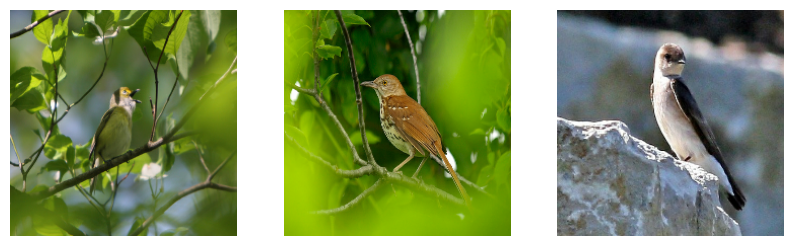

In [5]:
# class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validate_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Question (1) (c) (i) (ii)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height=224, width=224),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2)),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

2022-12-11 16:08:00.560506: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-11 16:08:02.216609: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-11 16:08:03.897172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191
2022-12-11 16:08:05.557550: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-11 16:08:07.105313: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9
2022-12-11 16:08:08.744638: W tensorflow/core/grappler/optimize

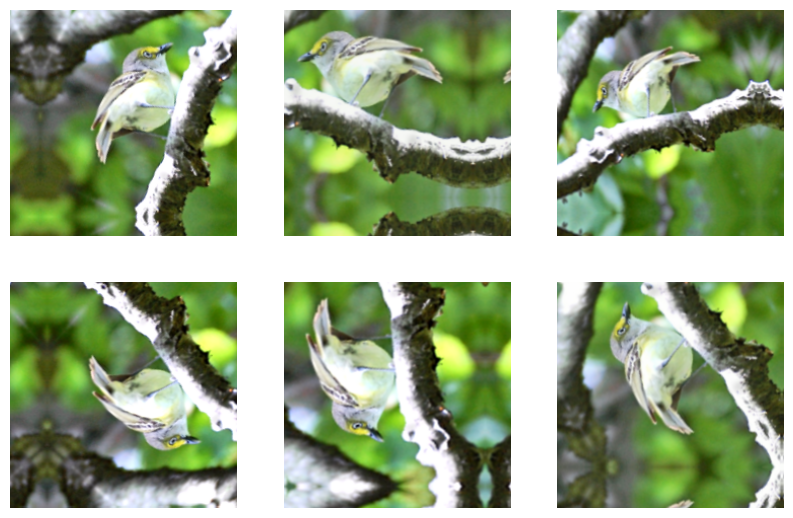

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Question (1) (c) (i) `EfficientNetB0`

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 7, 7, 1280)


In [11]:
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(21, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 21)


# Question (1) (c) (ii) (iii) `EfficientNetB0`

In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(name='EfficientNetB0', inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [16]:
model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1280)              1639680   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                    

In [17]:
len(model.trainable_variables)

4

In [18]:
loss0, accuracy0, precision0, recall0 = model.evaluate(validate_dataset)

37/37 [==============================] - 5s 86ms/step - loss: 3.0279 - accuracy: 0.0541 - precision: 0.0000e+00 - recall: 0.0000e+00


In [19]:
print('EffecientNetB0')
print("Initial Loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))
print("Initial Precision: {:.2f}".format(precision0))
print("Initial Recall: {:.2f}".format(recall0))

EffecientNetB0
Initial Loss: 3.03
Initial Accuracy: 0.05
Initial Precision: 0.00
Initial Recall: 0.00


# Question (1) (c) (iv) `EfficientNetB0`

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validate_dataset,
                    callbacks=[callback])

Epoch 1/100


2022-12-11 16:08:21.446591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: EfficientNetB0/sequential/random_crop/loop_body/cond/branch_executed/_9


173/173 [==============================] - 26s 119ms/step - loss: 1.2534 - accuracy: 0.6277 - precision: 0.7676 - recall: 0.5040 - val_loss: 0.4785 - val_accuracy: 0.8432 - val_precision: 0.8963 - val_recall: 0.7946
Epoch 2/100
173/173 [==============================] - 20s 114ms/step - loss: 0.5069 - accuracy: 0.8358 - precision: 0.8797 - recall: 0.8035 - val_loss: 0.3756 - val_accuracy: 0.8865 - val_precision: 0.9138 - val_recall: 0.8595
Epoch 3/100
173/173 [==============================] - 17s 101ms/step - loss: 0.4319 - accuracy: 0.8578 - precision: 0.8798 - recall: 0.8289 - val_loss: 0.3859 - val_accuracy: 0.8811 - val_precision: 0.8989 - val_recall: 0.8649
Epoch 4/100
173/173 [==============================] - 17s 100ms/step - loss: 0.3485 - accuracy: 0.8948 - precision: 0.9124 - recall: 0.8786 - val_loss: 0.3875 - val_accuracy: 0.9135 - val_precision: 0.9375 - val_recall: 0.8919
Epoch 5/100
173/173 [==============================] - 16s 90ms/step - loss: 0.2698 - accuracy: 0.91

173/173 [==============================] - 15s 89ms/step - loss: 0.0948 - accuracy: 0.9792 - precision: 0.9803 - recall: 0.9769 - val_loss: 0.5831 - val_accuracy: 0.9189 - val_precision: 0.9227 - val_recall: 0.9027
Epoch 38/100
173/173 [==============================] - 14s 82ms/step - loss: 0.1316 - accuracy: 0.9688 - precision: 0.9722 - recall: 0.9688 - val_loss: 0.7333 - val_accuracy: 0.9027 - val_precision: 0.9027 - val_recall: 0.9027
Epoch 39/100
173/173 [==============================] - 15s 85ms/step - loss: 0.1245 - accuracy: 0.9746 - precision: 0.9757 - recall: 0.9746 - val_loss: 0.8134 - val_accuracy: 0.8973 - val_precision: 0.9071 - val_recall: 0.8973
Epoch 40/100
173/173 [==============================] - 15s 89ms/step - loss: 0.1451 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - val_loss: 1.0888 - val_accuracy: 0.8865 - val_precision: 0.8852 - val_recall: 0.8757
Epoch 41/100
173/173 [==============================] - 15s 85ms/step - loss: 0.1097 - accuracy: 0.97

Epoch 73/100
173/173 [==============================] - 15s 89ms/step - loss: 0.0542 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - val_loss: 1.1266 - val_accuracy: 0.8919 - val_precision: 0.8919 - val_recall: 0.8919
Epoch 74/100
173/173 [==============================] - 16s 90ms/step - loss: 0.0924 - accuracy: 0.9803 - precision: 0.9826 - recall: 0.9792 - val_loss: 1.0285 - val_accuracy: 0.9027 - val_precision: 0.9027 - val_recall: 0.9027
Epoch 75/100
173/173 [==============================] - 15s 89ms/step - loss: 0.0299 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - val_loss: 0.8582 - val_accuracy: 0.9135 - val_precision: 0.9130 - val_recall: 0.9081
Epoch 76/100
173/173 [==============================] - 16s 90ms/step - loss: 0.0377 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - val_loss: 0.9549 - val_accuracy: 0.9081 - val_precision: 0.9071 - val_recall: 0.8973
Epoch 77/100
173/173 [==============================] - 16s 92ms/step - loss: 0.0723 - a

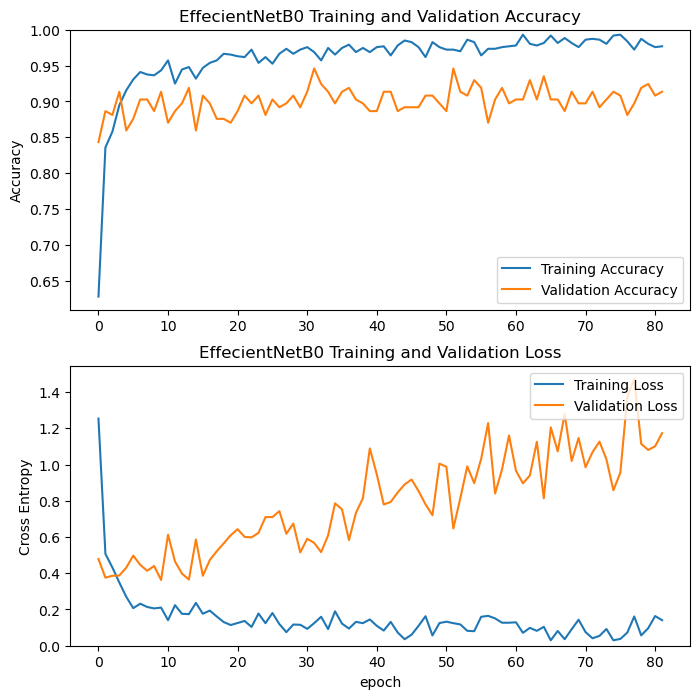

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('EffecientNetB0 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('EffecientNetB0 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Question (1) (c) (v) `EfficientNetB0`

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print('EffecientNetB0')
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', (2 * precision * recall) / (precision + recall))

38/38 [==============================] - 3s 67ms/step - loss: 0.3968 - accuracy: 0.9462 - precision: 0.9514 - recall: 0.9462
EffecientNetB0
Test Accuracy: 0.9462365508079529
Test Loss: 0.3968105912208557
Test Precision: 0.9513513445854187
Test Recall: 0.9462365508079529
Test F1 Score: 0.9487870544414512


# Question (1) (c) (i) `VGG16`

In [37]:
base_model = tf.keras.applications.VGG16(include_top=False)

In [38]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 7, 7, 512)


In [39]:
base_model.trainable = False

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 512)


In [41]:
prediction_layer = tf.keras.layers.Dense(21, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 21)


# Question (1) (c) (ii) (iii) `VGG16`

In [42]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(name='VGG16', inputs=inputs, outputs=outputs)

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [44]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                             

In [45]:
len(model.trainable_variables)

4

In [46]:
loss0, accuracy0, precision0, recall0 = model.evaluate(validate_dataset)

37/37 [==============================] - 11s 291ms/step - loss: 10.5072 - accuracy: 0.0378 - precision_2: 0.0470 - recall_2: 0.0378


In [47]:
print('VGG16')
print("Initial Loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))
print("Initial Precision: {:.2f}".format(precision0))
print("Initial Recall: {:.2f}".format(recall0))

VGG16
Initial Loss: 10.51
Initial Accuracy: 0.04
Initial Precision: 0.05
Initial Recall: 0.04


# Question (1) (c) (iv) `VGG16`

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validate_dataset,
                    callbacks=[callback])

Epoch 1/100


2022-12-11 18:55:04.587778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: VGG16/sequential/random_crop/loop_body/cond/branch_executed/_9


173/173 [==============================] - 67s 362ms/step - loss: 4.0490 - accuracy: 0.2358 - precision_2: 0.2747 - recall_2: 0.1572 - val_loss: 2.0159 - val_accuracy: 0.4703 - val_precision_2: 0.5802 - val_recall_2: 0.4108
Epoch 2/100
173/173 [==============================] - 63s 363ms/step - loss: 1.9469 - accuracy: 0.4532 - precision_2: 0.5833 - recall_2: 0.3156 - val_loss: 1.8119 - val_accuracy: 0.5568 - val_precision_2: 0.6000 - val_recall_2: 0.5027
Epoch 3/100
173/173 [==============================] - 63s 364ms/step - loss: 1.5777 - accuracy: 0.5399 - precision_2: 0.6820 - recall_2: 0.4116 - val_loss: 1.4975 - val_accuracy: 0.6324 - val_precision_2: 0.6981 - val_recall_2: 0.6000
Epoch 4/100
173/173 [==============================] - 63s 363ms/step - loss: 1.2637 - accuracy: 0.6197 - precision_2: 0.7508 - recall_2: 0.5225 - val_loss: 1.5658 - val_accuracy: 0.6162 - val_precision_2: 0.6386 - val_recall_2: 0.5730
Epoch 5/100
173/173 [==============================] - 63s 364ms/ste

Epoch 36/100
173/173 [==============================] - 63s 364ms/step - loss: 0.4160 - accuracy: 0.8763 - precision_2: 0.8963 - recall_2: 0.8590 - val_loss: 2.2633 - val_accuracy: 0.7027 - val_precision_2: 0.7299 - val_recall_2: 0.6865
Epoch 37/100
173/173 [==============================] - 63s 365ms/step - loss: 0.3358 - accuracy: 0.8994 - precision_2: 0.9162 - recall_2: 0.8717 - val_loss: 2.4160 - val_accuracy: 0.7135 - val_precision_2: 0.7174 - val_recall_2: 0.7135
Epoch 38/100
173/173 [==============================] - 63s 364ms/step - loss: 0.5493 - accuracy: 0.8532 - precision_2: 0.8717 - recall_2: 0.8324 - val_loss: 1.6144 - val_accuracy: 0.7351 - val_precision_2: 0.7444 - val_recall_2: 0.7243
Epoch 39/100
173/173 [==============================] - 63s 365ms/step - loss: 0.4021 - accuracy: 0.8844 - precision_2: 0.8952 - recall_2: 0.8590 - val_loss: 2.1923 - val_accuracy: 0.6757 - val_precision_2: 0.6851 - val_recall_2: 0.6703
Epoch 40/100
173/173 [==============================

173/173 [==============================] - 63s 364ms/step - loss: 0.3029 - accuracy: 0.9156 - precision_2: 0.9237 - recall_2: 0.9098 - val_loss: 2.8316 - val_accuracy: 0.6919 - val_precision_2: 0.6919 - val_recall_2: 0.6919
Epoch 71/100
173/173 [==============================] - 63s 363ms/step - loss: 0.2252 - accuracy: 0.9387 - precision_2: 0.9482 - recall_2: 0.9318 - val_loss: 2.6310 - val_accuracy: 0.7514 - val_precision_2: 0.7596 - val_recall_2: 0.7514
Epoch 72/100
173/173 [==============================] - 63s 362ms/step - loss: 0.3324 - accuracy: 0.9040 - precision_2: 0.9109 - recall_2: 0.8983 - val_loss: 2.5907 - val_accuracy: 0.7243 - val_precision_2: 0.7308 - val_recall_2: 0.7189
Epoch 73/100
173/173 [==============================] - 62s 361ms/step - loss: 0.3652 - accuracy: 0.9040 - precision_2: 0.9164 - recall_2: 0.8994 - val_loss: 2.2191 - val_accuracy: 0.7622 - val_precision_2: 0.7705 - val_recall_2: 0.7622
Epoch 74/100
173/173 [==============================] - 63s 365ms

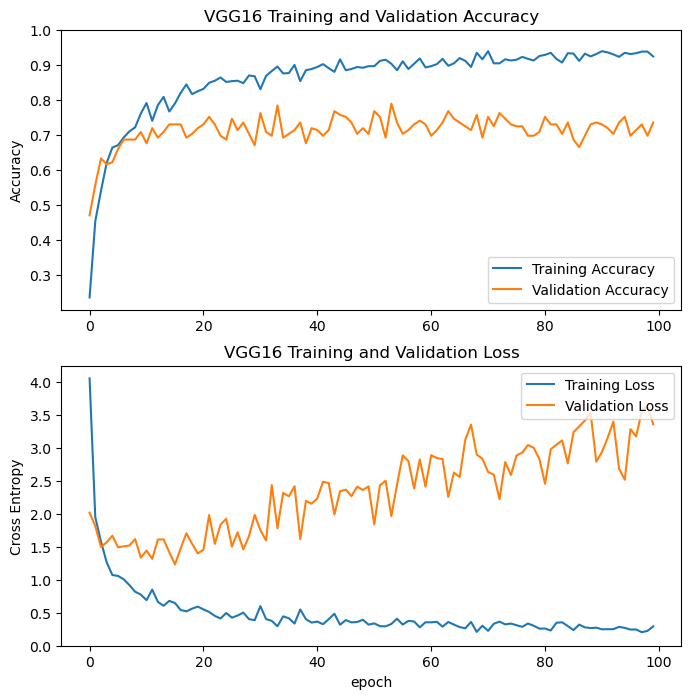

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('VGG16 Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Question (1) (c) (v) `VGG16`

In [50]:
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print('VGG16')
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', (2 * precision * recall) / (precision + recall))

38/38 [==============================] - 11s 284ms/step - loss: 2.7681 - accuracy: 0.7957 - precision_2: 0.8033 - recall_2: 0.7903
VGG16
Test Accuracy: 0.7956989407539368
Test Loss: 2.76812744140625
Test Precision: 0.8032786846160889
Test Recall: 0.7903226017951965
Test F1 Score: 0.7967479763047394
